In [4]:
import os
import pickle
import pandas as pd
from falkordb import FalkorDB
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from dotenv import load_dotenv, find_dotenv
from services import logging_config

[2025-11-14 15:33:13] INFO     - root - ================================================================================
[2025-11-14 15:33:13] INFO     - root - Logging initialized
[2025-11-14 15:33:13] INFO     - root - Log level: INFO
[2025-11-14 15:33:13] INFO     - root - Log directory: /Users/joshuaziel/Documents/Coding/glp-1_landscape/logs
[2025-11-14 15:33:13] INFO     - root - Console logging: True
[2025-11-14 15:33:13] INFO     - root - ================================================================================


In [5]:
# Load environment variables
load_dotenv(find_dotenv())

# Initialize logger
logger = logging_config.get_logger(__name__)

#Set data location
DATA_STORAGE = os.getenv("DATA_LOC", None)

if DATA_STORAGE and Path(DATA_STORAGE).exists():
    logger.info(f"Data will be saved at:{DATA_STORAGE}")
else:
    DATA_STORAGE = Path(__file__).resolve()
    logger.warning(f"Warning: Data storage path in environment does not exist or was not set, saving data here: {DATA_STORAGE}")

[2025-11-14 15:33:15] INFO     - __main__ - Data will be saved at:/Users/joshuaziel/Documents/Coding/glp-1_landscape/data


In [6]:
annotated_trials_loc = f"{DATA_STORAGE}/annotated_trials_20251113114130.pkl"
if Path(annotated_trials_loc).exists():
    with open(annotated_trials_loc, "rb") as f:
        annotated_trials = pickle.load(f)
else:
    logger.error("Check the path to the pickle!")

# Exploratory Data Analysis

Let's analyze trends and patterns in the clinical trials data.

In [10]:
# Load data from pickle for analysis
df_copy = annotated_trials.copy()
mask = df['cln_start_date'] < '2025-01-01'
df = df_copy[mask]


# Convert date columns to datetime if needed
if not pd.api.types.is_datetime64_any_dtype(df['cln_start_date']):
    df['cln_start_date'] = pd.to_datetime(df['cln_start_date'])
if not pd.api.types.is_datetime64_any_dtype(df['cln_completion_date']):
    df['cln_completion_date'] = pd.to_datetime(df['cln_completion_date'])

# Extract year from start date
df['start_year'] = df['cln_start_date'].dt.year.astype('Int64')

print(f"Total trials: {len(df)}")
print(f"Date range: {df['start_year'].min()} - {df['start_year'].max()}")
print(f"\nTherapeutic categories:")
if 'therapeutic_category' in df.columns:
    print(df['therapeutic_category'].explode().value_counts())
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Total trials: 1105
Date range: 1999 - 2024

Therapeutic categories:
therapeutic_category
ENDOCRINOLOGY             914
GASTROINTESTINAL           44
CARDIOVASCULAR             39
CENTRAL_NERVOUS_SYSTEM     28
NEPHROLOGY                 26
OTHER                      11
DERMATOLOGY                 7
HEMATOLOGY                  6
INFECTIOUS_DISEASES         4
DIAGNOSTICS                 3
RESPIRATORY                 3
RHEUMATOLOGY                3
PAIN_MANAGEMENT             3
ONCOLOGY                    3
WOMENS_HEALTH               2
MEDICAL_DEVICES             1
PEDIATRICS                  1
Name: count, dtype: int64

Columns: ['nct_id', 'official_title', 'brief_title', 'acronym', 'overall_status', 'start_date', 'completion_date', 'last_update_date', 'brief_summary', 'detailed_description', 'conditions', 'interventions', 'intervention_types', 'lead_sponsor', 'sponsor_class', 'collaborators', 'countries', 'facilities', 'min_age', 'max_age', 'gender', 'healthy_volunteers', 'study_type', 

/var/folders/k1/2mq18dfd24xfb23cgc_1k4dm0000gn/T/ipykernel_11880/1722769729.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_year'] = df['cln_start_date'].dt.year.astype('Int64')


,nct_id,official_title,brief_title,acronym,overall_status,start_date,completion_date,last_update_date,brief_summary,detailed_description,...,citation,drug_name,cleaned_sponsor,cln_start_date,cln_completion_date,duration,matched_conditions,llm_annotations,therapeutic_category,start_year
830,NCT00035984,"A Phase 3, Randomized, Triple-Blind, Parallel-...",Evaluation of the Effect on Glucose Control of...,,COMPLETED,2002-05,2003-08,2015-02-24,"This is a multicenter, randomized, blinded, pl...",None,...,"A Phase 3, Randomized, Triple-Blind, Parallel-...",[EXENATIDE],ASTRAZENECA,2002-05-01,2003-08-01,1.3,"[Diabetes Mellitus, Type 2 (MeSH ID:68003924)]",[therapeutic_category],[ENDOCRINOLOGY],2002
1085,NCT00039013,"A Phase 3, Randomized, Triple-Blind, Parallel-...",Evaluation of the Effect on Glucose Control of...,,COMPLETED,2002-03,2003-06,2015-02-24,"This is a multicenter, randomized, blinded, pl...",None,...,"A Phase 3, Randomized, Triple-Blind, Parallel-...",[EXENATIDE],ASTRAZENECA,2002-03-01,2003-06-01,1.3,"[Diabetes Mellitus, Type 2 (MeSH ID:68003924)]",[therapeutic_category],[ENDOCRINOLOGY],2002
1184,NCT00039026,"A Phase 3, Randomized, Triple-Blind, Parallel-...",Evaluation of the Effect on Glucose Control of...,,COMPLETED,2002-02,2003-08,2015-02-24,"This is a multicenter, randomized, blinded, pl...",None,...,"A Phase 3, Randomized, Triple-Blind, Parallel-...",[EXENATIDE],ASTRAZENECA,2002-02-01,2003-08-01,1.5,"[Diabetes Mellitus, Type 2 (MeSH ID:68003924)]",[therapeutic_category],[ENDOCRINOLOGY],2002
1028,NCT00044668,An Open-Label Study to Examine the Long-Term E...,Evaluation of the Effect on Glucose Control an...,,COMPLETED,2002-08,2005-09,2015-02-20,"This multi-center, open-label study is designe...",None,...,An Open-Label Study to Examine the Long-Term E...,[EXENATIDE],ASTRAZENECA,2002-08-01,2005-09-01,3.1,"[Diabetes Mellitus, Type 2 (MeSH ID:68003924)]",[therapeutic_category],[ENDOCRINOLOGY],2002
1007,NCT00044694,"A Phase 2, Randomized, Triple-Blind, Placebo-C...",Evaluation of the Effect on Glucose Control an...,,COMPLETED,2002-08,2003-05,2015-02-20,"This is a multicenter, randomized, blinded, pl...",None,...,"A Phase 2, Randomized, Triple-Blind, Placebo-C...",[EXENATIDE],ASTRAZENECA,2002-08-01,2003-05-01,0.7,"[Diabetes Mellitus, Type 2 (MeSH ID:68003924)]",[therapeutic_category],[ENDOCRINOLOGY],2002


## 1. Therapeutic Category Trends Over Time

How has the focus on ENDOCRINOLOGY vs other therapeutic areas changed over time?

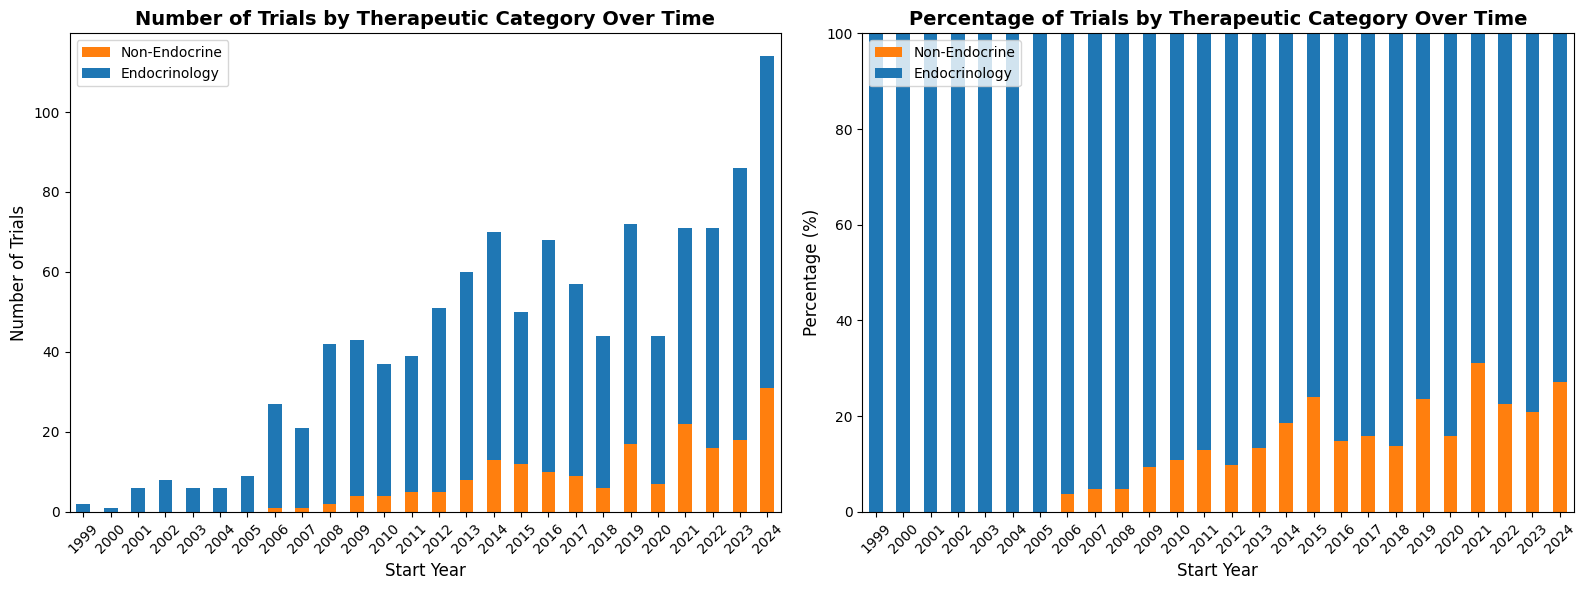


Overall percentage of ENDOCRINOLOGY trials: 82.7%

Trials per year:
is_endocrine  False  True 
start_year                
1999              0      2
2000              0      1
2001              0      6
2002              0      8
2003              0      6
2004              0      6
2005              0      9
2006              1     26
2007              1     20
2008              2     40
2009              4     39
2010              4     33
2011              5     34
2012              5     46
2013              8     52
2014             13     57
2015             12     38
2016             10     58
2017              9     48
2018              6     38
2019             17     55
2020              7     37
2021             22     49
2022             16     55
2023             18     68
2024             31     83


In [11]:
# Explode the tx_category column to handle multiple categories per trial
df_exploded = df.explode('therapeutic_category')

# Create binary indicator for ENDOCRINOLOGY
df_exploded['is_endocrine'] = df_exploded['therapeutic_category'] == 'ENDOCRINOLOGY'

# Group by year and calculate percentages
yearly_category = df_exploded.groupby(['start_year', 'is_endocrine']).size().unstack(fill_value=0)
yearly_category_pct = yearly_category.div(yearly_category.sum(axis=1), axis=0) * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Absolute counts
yearly_category.plot(kind='bar', stacked=True, ax=ax1, color=['#ff7f0e', '#1f77b4'])
ax1.set_title('Number of Trials by Therapeutic Category Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Start Year', fontsize=12)
ax1.set_ylabel('Number of Trials', fontsize=12)
ax1.legend(['Non-Endocrine', 'Endocrinology'], loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Percentages
yearly_category_pct.plot(kind='bar', stacked=True, ax=ax2, color=['#ff7f0e', '#1f77b4'])
ax2.set_title('Percentage of Trials by Therapeutic Category Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Start Year', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.legend(['Non-Endocrine', 'Endocrinology'], loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nOverall percentage of ENDOCRINOLOGY trials: {(df_exploded['is_endocrine'].sum() / len(df_exploded) * 100):.1f}%")
print(f"\nTrials per year:")
print(yearly_category)

### 1.1 Non-Endocrine Therapeutic Categories and Conditions

What other therapeutic areas are GLP-1 drugs being explored for?

NON-ENDOCRINE THERAPEUTIC CATEGORIES AND THEIR CONDITIONS

GASTROINTESTINAL (44 trials):
  1. Non-alcoholic Fatty Liver Disease (MeSH ID:68065626): 35 trials
  2. Diabetes Mellitus, Type 2 (MeSH ID:68003924): 8 trials
  3. Polycystic Ovary Syndrome (MeSH ID:68011085): 5 trials
  4. Short Bowel Syndrome (MeSH ID:68012778): 3 trials
  5. Obesity (MeSH ID:68009765): 3 trials

CARDIOVASCULAR (39 trials):
  1. Myocardial Infarction (MeSH ID:68009203): 8 trials
  2. Diabetes Mellitus, Type 2 (MeSH ID:68003924): 6 trials
  3. Ischemic Stroke (MeSH ID:2052021): 5 trials
  4. Heart Failure (MeSH ID:68006333): 5 trials
  5. Cardiovascular Diseases (MeSH ID:68002318): 4 trials

CENTRAL_NERVOUS_SYSTEM (28 trials):
  1. Parkinson Disease (MeSH ID:68010300): 10 trials
  2. Alzheimer Disease (MeSH ID:68000544): 7 trials
  3. Schizophrenia (MeSH ID:68012559): 4 trials
  4. Cognitive Dysfunction (MeSH ID:68060825): 3 trials
  5. Obesity (MeSH ID:68009765): 3 trials

NEPHROLOGY (26 trials):
  1. Diabeti

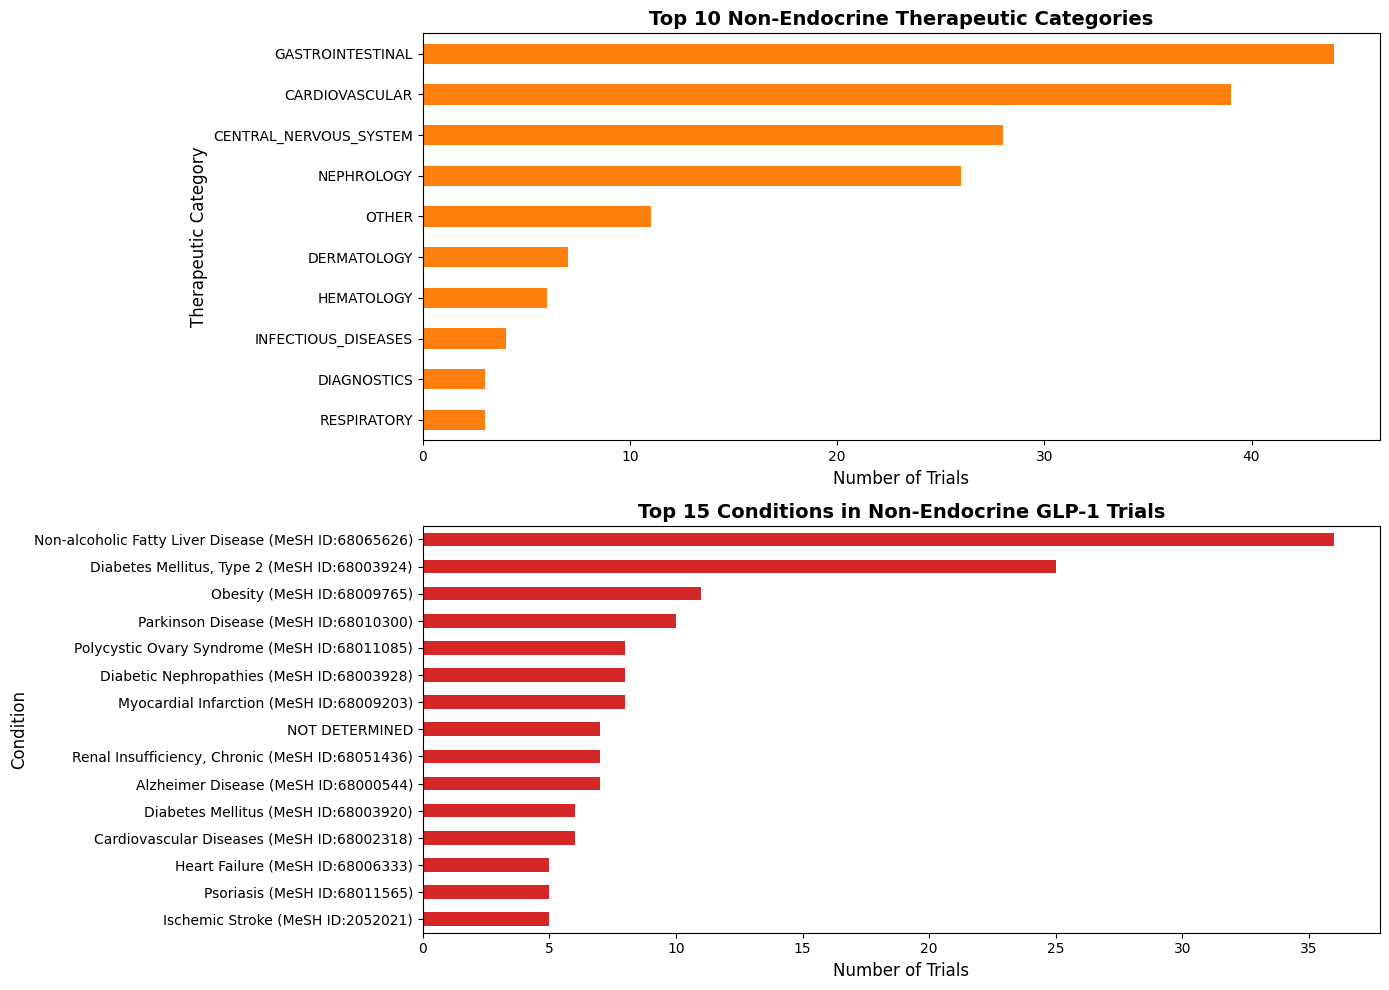


SUMMARY:
Total trials: 1105
Non-endocrine trials: 191 (17.3%)
Unique non-endocrine therapeutic categories: 16
Unique conditions in non-endocrine trials: 103


In [28]:
# Filter for non-endocrine trials
df_nonendocrine = df_exploded[df_exploded['therapeutic_category'] != 'ENDOCRINOLOGY'].copy()
df_nonendocrine_unique = df_nonendocrine.drop_duplicates(subset='nct_id')

# Get top non-endocrine therapeutic categories
nonendocrine_categories = df_nonendocrine_unique['therapeutic_category'].value_counts().head(10)

# For each top category, get the most common conditions
print("="*80)
print("NON-ENDOCRINE THERAPEUTIC CATEGORIES AND THEIR CONDITIONS")
print("="*80)

category_conditions = {}
for category in nonendocrine_categories.index:
    # Filter for this category
    category_df = df_nonendocrine[df_nonendocrine['therapeutic_category'] == category].copy()
    
    # Explode matched_conditions
    category_conditions_exploded = category_df.explode('matched_conditions')
    df_nonendocrine_unique = df_nonendocrine.drop_duplicates(subset='nct_id')
    
    # Get top conditions
    top_conditions = category_conditions_exploded['matched_conditions'].value_counts().head(5)
    category_conditions[category] = top_conditions
    
    print(f"\n{category} ({len(category_df)} trials):")
    for i, (condition, count) in enumerate(top_conditions.items(), 1):
        print(f"  {i}. {condition}: {count} trials")

# Visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top non-endocrine categories
ax1 = axes[0]
nonendocrine_categories.plot(kind='barh', ax=ax1, color='#ff7f0e')
ax1.set_title('Top 10 Non-Endocrine Therapeutic Categories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Trials', fontsize=12)
ax1.set_ylabel('Therapeutic Category', fontsize=12)
ax1.invert_yaxis()

# Most common conditions in non-endocrine trials
ax2 = axes[1]
all_nonendocrine_conditions = df_nonendocrine.explode('matched_conditions')['matched_conditions'].value_counts().head(15)
all_nonendocrine_conditions.plot(kind='barh', ax=ax2, color='#d62728')
ax2.set_title('Top 15 Conditions in Non-Endocrine GLP-1 Trials', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Trials', fontsize=12)
ax2.set_ylabel('Condition', fontsize=12)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Summary stats
print("\n" + "="*80)
print(f"SUMMARY:")
print(f"Total trials: {len(df)}")
print(f"Non-endocrine trials: {len(df_nonendocrine)} ({len(df_nonendocrine)/len(df_exploded)*100:.1f}%)")
print(f"Unique non-endocrine therapeutic categories: {df_nonendocrine['therapeutic_category'].nunique()}")
print(f"Unique conditions in non-endocrine trials: {df_nonendocrine.explode('matched_conditions')['matched_conditions'].nunique()}")
print("="*80)

### 1.2 Non-Endocrine Sponsors and Drug Investment

Which organizations and drugs are driving GLP-1 research beyond endocrinology?

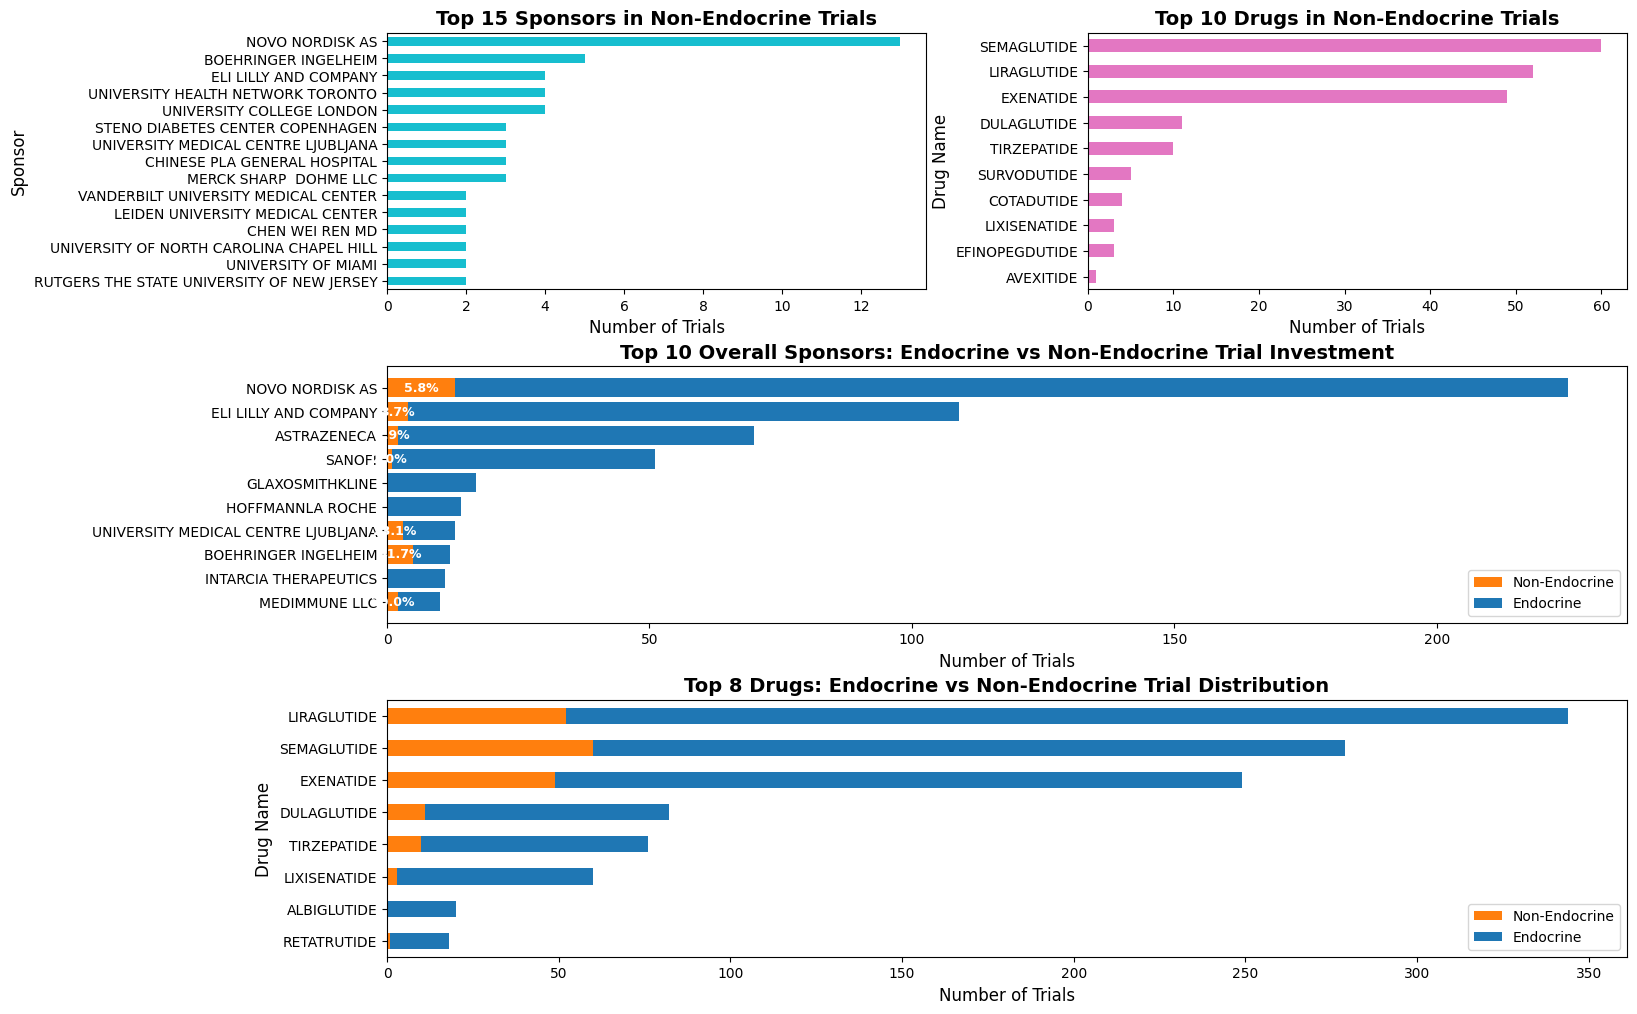

SPONSOR INVESTMENT IN NON-ENDOCRINE TRIALS

Top 10 sponsors by non-endocrine trial count:
1. NOVO NORDISK AS: 13 non-endocrine trials (5.8% of their portfolio)
2. BOEHRINGER INGELHEIM: 5 non-endocrine trials (41.7% of their portfolio)
3. ELI LILLY AND COMPANY: 4 non-endocrine trials (3.7% of their portfolio)
4. UNIVERSITY HEALTH NETWORK TORONTO: 4 non-endocrine trials (80.0% of their portfolio)
5. UNIVERSITY COLLEGE LONDON: 4 non-endocrine trials (66.7% of their portfolio)
6. STENO DIABETES CENTER COPENHAGEN: 3 non-endocrine trials (60.0% of their portfolio)
7. UNIVERSITY MEDICAL CENTRE LJUBLJANA: 3 non-endocrine trials (23.1% of their portfolio)
8. CHINESE PLA GENERAL HOSPITAL: 3 non-endocrine trials (100.0% of their portfolio)
9. MERCK SHARP  DOHME LLC: 3 non-endocrine trials (50.0% of their portfolio)
10. VANDERBILT UNIVERSITY MEDICAL CENTER: 2 non-endocrine trials (33.3% of their portfolio)

DRUGS IN NON-ENDOCRINE TRIALS

Top 10 drugs in non-endocrine research:
1. SEMAGLUTIDE: 60 n

In [16]:
# Get unique non-endocrine trials (de-duplicate the exploded dataframe)
df_nonendocrine_unique = df_nonendocrine.drop_duplicates(subset='nct_id')

# Top sponsors in non-endocrine trials
nonendocrine_sponsors = df_nonendocrine_unique['cleaned_sponsor'].value_counts().head(15)

# Top drugs in non-endocrine trials
df_nonendocrine_drugs = df_nonendocrine_unique.explode('drug_name')
nonendocrine_drugs = df_nonendocrine_drugs['drug_name'].value_counts().head(10)

# Compare sponsor involvement: endocrine vs non-endocrine
top_overall_sponsors = df['cleaned_sponsor'].value_counts().head(10).index.tolist()
sponsor_comparison = []
for sponsor in top_overall_sponsors:
    total_trials = len(df[df['cleaned_sponsor'] == sponsor])
    # Get non-endocrine trials for this sponsor
    sponsor_trials = df[df['cleaned_sponsor'] == sponsor]
    sponsor_trials_exploded = sponsor_trials.explode('therapeutic_category')
    nonendocrine_trials = len(sponsor_trials_exploded[sponsor_trials_exploded['therapeutic_category'] != 'ENDOCRINOLOGY'].drop_duplicates(subset='nct_id'))
    
    sponsor_comparison.append({
        'sponsor': sponsor,
        'total': total_trials,
        'non_endocrine': nonendocrine_trials,
        'pct_non_endocrine': (nonendocrine_trials / total_trials * 100) if total_trials > 0 else 0
    })

sponsor_comparison_df = pd.DataFrame(sponsor_comparison)

# Visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Top sponsors in non-endocrine trials
ax1 = fig.add_subplot(gs[0, 0])
nonendocrine_sponsors.plot(kind='barh', ax=ax1, color='#17becf')
ax1.set_title('Top 15 Sponsors in Non-Endocrine Trials', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Trials', fontsize=12)
ax1.set_ylabel('Sponsor', fontsize=12)
ax1.invert_yaxis()

# Top drugs in non-endocrine trials
ax2 = fig.add_subplot(gs[0, 1])
nonendocrine_drugs.plot(kind='barh', ax=ax2, color='#e377c2')
ax2.set_title('Top 10 Drugs in Non-Endocrine Trials', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Trials', fontsize=12)
ax2.set_ylabel('Drug Name', fontsize=12)
ax2.invert_yaxis()

# Sponsor comparison: endocrine vs non-endocrine (stacked bar)
ax3 = fig.add_subplot(gs[1, :])
x = range(len(sponsor_comparison_df))
ax3.barh(x, sponsor_comparison_df['non_endocrine'], label='Non-Endocrine', color='#ff7f0e')
ax3.barh(x, sponsor_comparison_df['total'] - sponsor_comparison_df['non_endocrine'], 
         left=sponsor_comparison_df['non_endocrine'], label='Endocrine', color='#1f77b4')
ax3.set_yticks(x)
ax3.set_yticklabels(sponsor_comparison_df['sponsor'])
ax3.set_xlabel('Number of Trials', fontsize=12)
ax3.set_title('Top 10 Overall Sponsors: Endocrine vs Non-Endocrine Trial Investment', fontsize=14, fontweight='bold')
ax3.legend()
ax3.invert_yaxis()

# Add percentage labels
for i, row in sponsor_comparison_df.iterrows():
    if row['non_endocrine'] > 0:
        ax3.text(row['non_endocrine']/2, i, f"{row['pct_non_endocrine']:.1f}%", 
                va='center', ha='center', fontsize=9, fontweight='bold', color='white')

# Drug comparison across categories
ax4 = fig.add_subplot(gs[2, :])
top_drugs_overall = df.explode('drug_name')['drug_name'].value_counts().head(8).index.tolist()
drug_category_data = []

for drug in top_drugs_overall:
    drug_trials = df[df['drug_name'].apply(lambda x: drug in x if isinstance(x, list) else False)]
    drug_trials_exploded = drug_trials.explode('therapeutic_category')
    
    endocrine_count = len(drug_trials_exploded[drug_trials_exploded['therapeutic_category'] == 'ENDOCRINOLOGY'].drop_duplicates(subset='nct_id'))
    total_count = len(drug_trials)
    nonendocrine_count = total_count - endocrine_count
    
    drug_category_data.append({
        'drug': drug,
        'endocrine': endocrine_count,
        'non_endocrine': nonendocrine_count
    })

drug_category_df = pd.DataFrame(drug_category_data)
drug_category_df.set_index('drug')[['non_endocrine', 'endocrine']].plot(
    kind='barh', stacked=True, ax=ax4, color=['#ff7f0e', '#1f77b4']
)
ax4.set_title('Top 8 Drugs: Endocrine vs Non-Endocrine Trial Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Trials', fontsize=12)
ax4.set_ylabel('Drug Name', fontsize=12)
ax4.legend(['Non-Endocrine', 'Endocrine'])
ax4.invert_yaxis()

plt.show()

# Print detailed breakdown
print("="*80)
print("SPONSOR INVESTMENT IN NON-ENDOCRINE TRIALS")
print("="*80)
print("\nTop 10 sponsors by non-endocrine trial count:")
for i, (sponsor, count) in enumerate(nonendocrine_sponsors.head(10).items(), 1):
    total = len(df[df['cleaned_sponsor'] == sponsor])
    pct = (count / total * 100) if total > 0 else 0
    print(f"{i}. {sponsor}: {count} non-endocrine trials ({pct:.1f}% of their portfolio)")

print("\n" + "="*80)
print("DRUGS IN NON-ENDOCRINE TRIALS")
print("="*80)
print("\nTop 10 drugs in non-endocrine research:")
for i, (drug, count) in enumerate(nonendocrine_drugs.items(), 1):
    # Get total trials for this drug
    total = len(df[df['drug_name'].apply(lambda x: drug in x if isinstance(x, list) else False)])
    pct = (count / total * 100) if total > 0 else 0
    print(f"{i}. {drug}: {count} non-endocrine trials ({pct:.1f}% of drug's trials)")

print("\n" + "="*80)
print(f"Total unique sponsors in non-endocrine trials: {df_nonendocrine_unique['cleaned_sponsor'].nunique()}")
print(f"Total unique drugs in non-endocrine trials: {df_nonendocrine_drugs['drug_name'].nunique()}")
print("="*80)

## 4. Drug Landscape Analysis

Which GLP-1 drugs are most studied and when did they emerge?

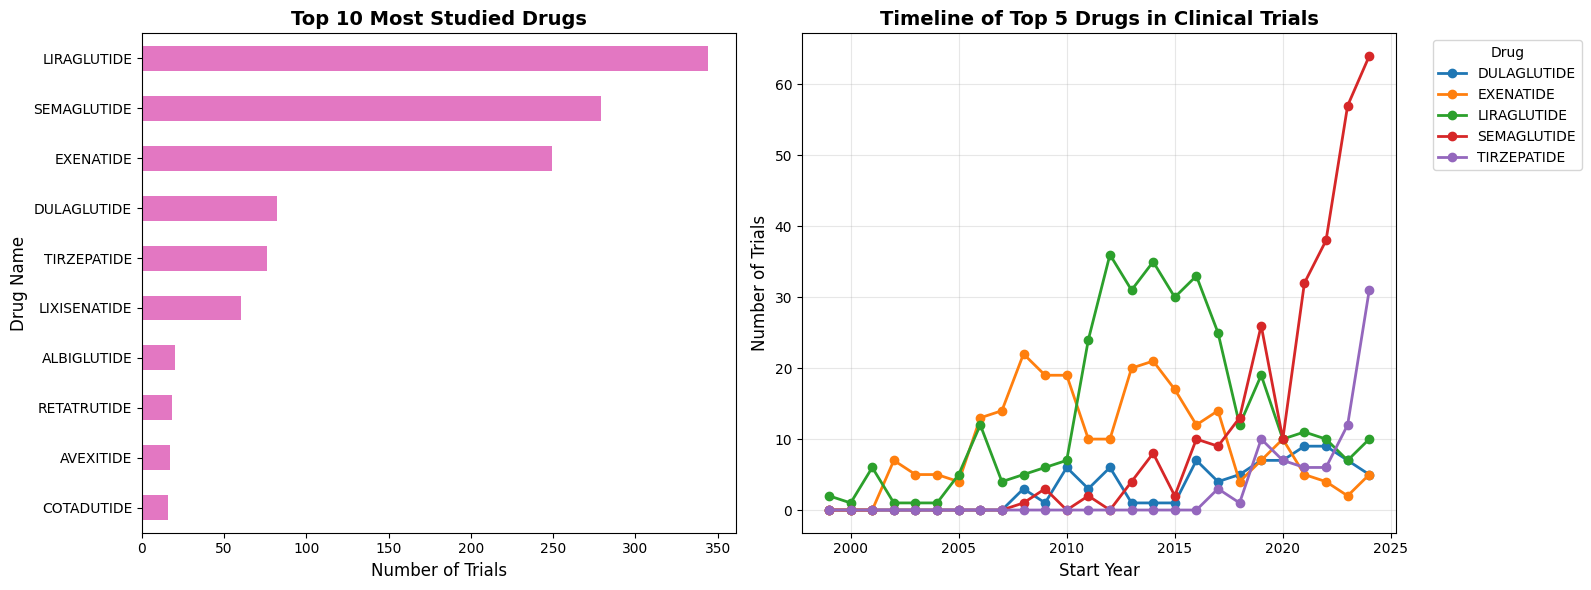


Top 10 Drugs:
1. LIRAGLUTIDE: 344 trials (first trial: 1999)
2. SEMAGLUTIDE: 279 trials (first trial: 2008)
3. EXENATIDE: 249 trials (first trial: 2002)
4. DULAGLUTIDE: 82 trials (first trial: 2008)
5. TIRZEPATIDE: 76 trials (first trial: 2017)
6. LIXISENATIDE: 60 trials (first trial: 2006)
7. ALBIGLUTIDE: 20 trials (first trial: 2006)
8. RETATRUTIDE: 18 trials (first trial: 2019)
9. AVEXITIDE: 17 trials (first trial: 2007)
10. COTADUTIDE: 16 trials (first trial: 2015)


In [17]:
# Explode drug_name column (it's a list)
df_drugs = df.explode('drug_name')

# Top drugs
top_drugs = df_drugs['drug_name'].value_counts().head(10)

# Drug emergence over time (for top 5 drugs)
top_5_drugs = top_drugs.head(5).index.tolist()
drug_timeline = df_drugs[df_drugs['drug_name'].isin(top_5_drugs)].groupby(['start_year', 'drug_name']).size().unstack(fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top drugs bar chart
ax1 = axes[0]
top_drugs.plot(kind='barh', ax=ax1, color='#e377c2')
ax1.set_title('Top 10 Most Studied Drugs', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Trials', fontsize=12)
ax1.set_ylabel('Drug Name', fontsize=12)
ax1.invert_yaxis()

# Drug timeline
ax2 = axes[1]
drug_timeline.plot(kind='line', ax=ax2, marker='o', linewidth=2)
ax2.set_title('Timeline of Top 5 Drugs in Clinical Trials', fontsize=14, fontweight='bold')
ax2.set_xlabel('Start Year', fontsize=12)
ax2.set_ylabel('Number of Trials', fontsize=12)
ax2.legend(title='Drug', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTop 10 Drugs:")
for i, (drug, count) in enumerate(top_drugs.items(), 1):
    first_year = df_drugs[df_drugs['drug_name'] == drug]['start_year'].min()
    print(f"{i}. {drug}: {count} trials (first trial: {first_year})")

## 5. Trial Status and Phase Distribution

Understanding the maturity and progression of GLP-1 clinical research.

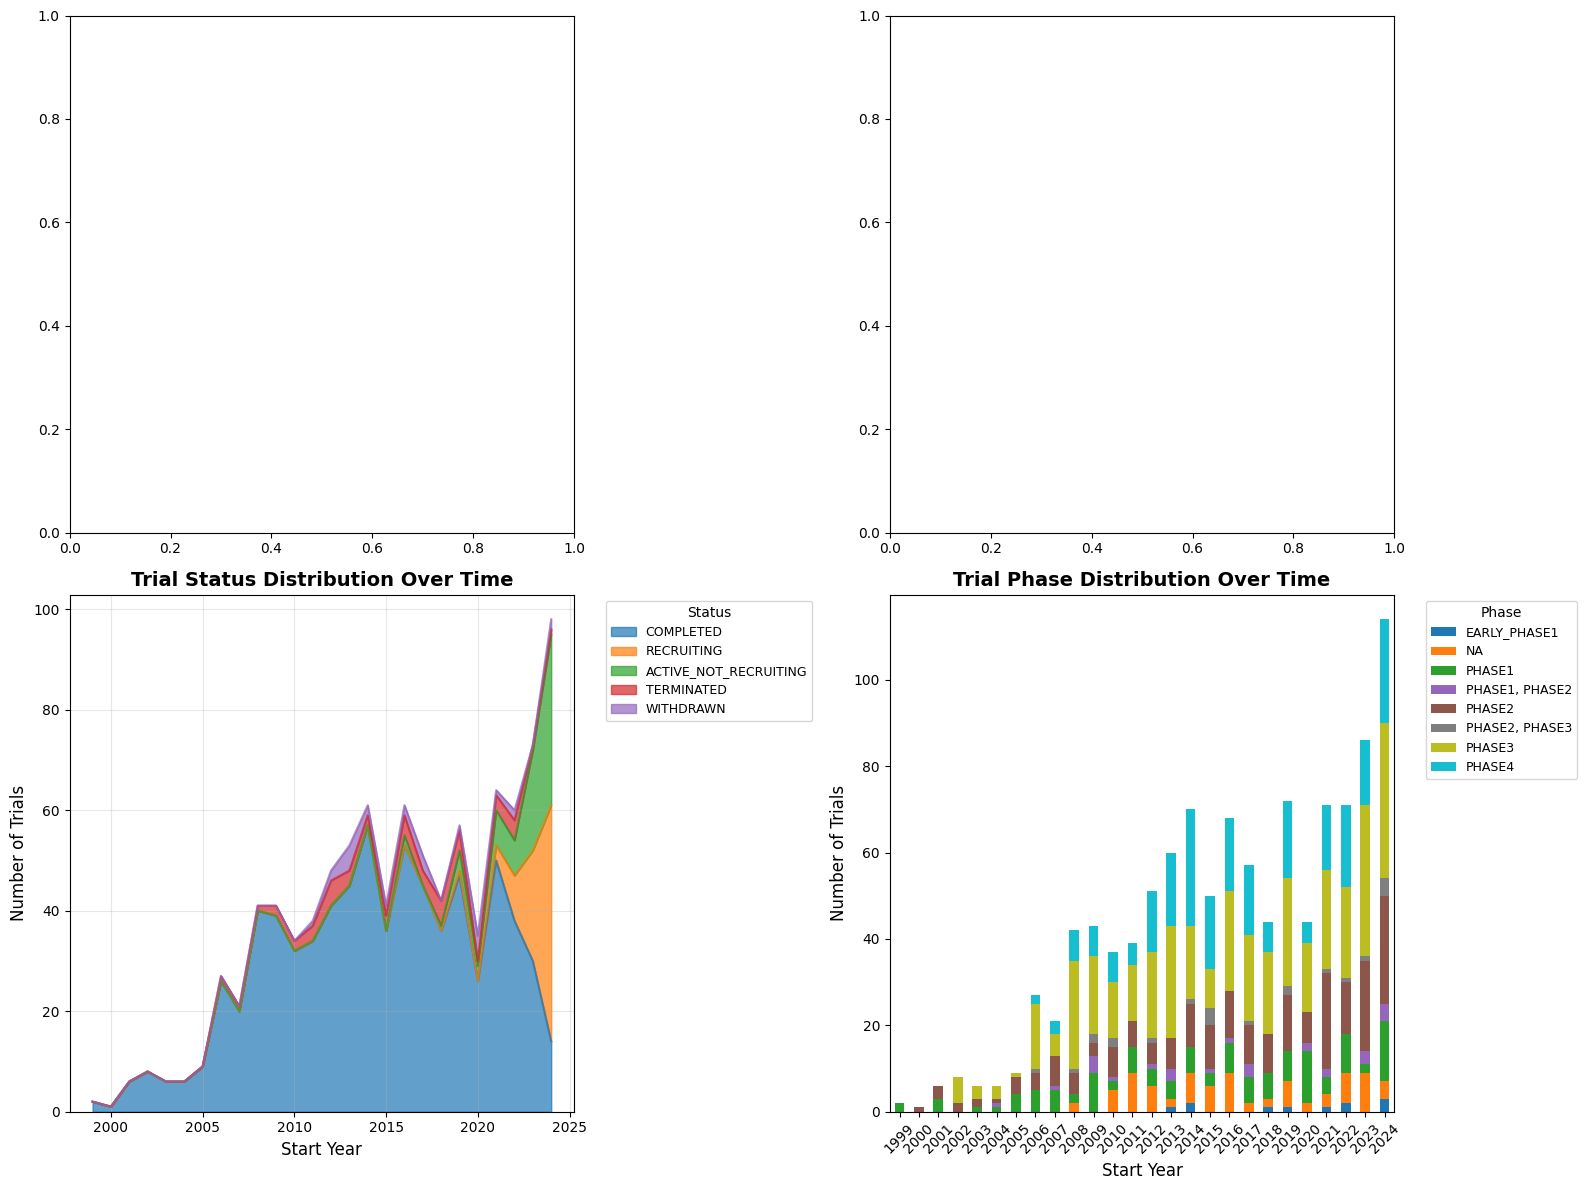


Trial Status Summary:
  COMPLETED: 747 (67.6%)
  UNKNOWN: 100 (9.0%)
  RECRUITING: 82 (7.4%)
  ACTIVE_NOT_RECRUITING: 78 (7.1%)
  TERMINATED: 49 (4.4%)
  WITHDRAWN: 28 (2.5%)
  NOT_YET_RECRUITING: 16 (1.4%)
  ENROLLING_BY_INVITATION: 4 (0.4%)
  SUSPENDED: 1 (0.1%)

Trial Phase Summary:
  PHASE3: 392 (35.5%)
  PHASE4: 242 (21.9%)
  PHASE2: 206 (18.6%)
  PHASE1: 124 (11.2%)
  NA: 81 (7.3%)
  PHASE1, PHASE2: 27 (2.4%)
  PHASE2, PHASE3: 22 (2.0%)
  EARLY_PHASE1: 11 (1.0%)


In [27]:
# Trial status and phase distributions
status_dist = df['overall_status'].value_counts()
phase_dist = df['phase'].value_counts()

# Status over time for major statuses
status_timeline = df.groupby(['start_year', 'overall_status']).size().unstack(fill_value=0)
major_statuses = ['COMPLETED', 'RECRUITING', 'ACTIVE_NOT_RECRUITING', 'TERMINATED', 'WITHDRAWN']
status_timeline_filtered = status_timeline[[col for col in major_statuses if col in status_timeline.columns]]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Status over time (stacked area)
ax3 = axes[1, 0]
status_timeline_filtered.plot(kind='area', ax=ax3, alpha=0.7, stacked=True)
ax3.set_title('Trial Status Distribution Over Time', fontsize=14, fontweight='bold')
ax3.set_xlabel('Start Year', fontsize=12)
ax3.set_ylabel('Number of Trials', fontsize=12)
ax3.legend(title='Status', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# Phase progression over time
phase_timeline = df.groupby(['start_year', 'phase']).size().unstack(fill_value=0)
ax4 = axes[1, 1]
if not phase_timeline.empty:
    phase_timeline.plot(kind='bar', stacked=True, ax=ax4, colormap='tab10')
    ax4.set_title('Trial Phase Distribution Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Start Year', fontsize=12)
    ax4.set_ylabel('Number of Trials', fontsize=12)
    ax4.legend(title='Phase', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nTrial Status Summary:")
for status, count in status_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {status}: {count} ({pct:.1f}%)")

print(f"\nTrial Phase Summary:")
for phase, count in phase_dist.items():
    pct = (count / len(df)) * 100
    print(f"  {phase}: {count} ({pct:.1f}%)")

## 6. Geographic Distribution and Correlation Analysis

Where are these trials being conducted, and what's the relationship between trial characteristics?

## Summary

This exploratory analysis reveals several key insights about GLP-1 clinical trials:

1. **Therapeutic Evolution**: Track how ENDOCRINOLOGY trials compare to other therapeutic areas over time
2. **Trial Complexity**: Understand trends in trial duration and participant enrollment
3. **Key Players**: Identify the most active sponsors in GLP-1 research
4. **Drug Landscape**: See which drugs dominate the research landscape and when they emerged
5. **Trial Progress**: Analyze the distribution of trial statuses and phases
6. **Global Reach**: Examine geographic distribution and correlations between trial characteristics

In [29]:
db = FalkorDB(host='localhost', port=6379)
g = db.select_graph(os.getenv("GRAPH_NAME"))
#g.delete()

In [30]:
def add_trial_to_graph(g, row):
    # Single parameterized query for all nodes and relationships
    query = """
MERGE (t:ClinicalTrial {nct_id: $nct_id})
SET t.title = $title,
    t.acronym = $acronym,
    t.trial_status = $status,
    t.start_date = $start_date,
    t.completion_date = $completion_date,
    t.approximate_duration_years = $approximate_duration_years,
    t.brief_description = $brief_description,
    t.detailed_description = $detailed_description,
    t.sponsor_class = $sponsor_class

MERGE (s:Sponsor {name: $sponsor_name})
    
MERGE (s)-[:SPONSORED]->(t)

WITH t
UNWIND $mapped_conditions as condition_name
MERGE (c:Condition {name: condition_name})
MERGE (t)-[:INCLUDED]->(c)

WITH t
UNWIND $tx_category as category_name 
MERGE (g:TxCategory {name: category_name})
MERGE (g)-[:RELEVANT_FOR]->(t)

WITH t
UNWIND $drugs as drug_name
MERGE (d:Drug {name: drug_name})
MERGE (t)-[:INVESTIGATED]->(d)
"""
    params = {
        'nct_id': row.nct_id,
        'drugs': row.drug_name,
        'title': row.official_title if hasattr(row, 'official_title') else "Not Available",
        'brief_title': row.brief_title if hasattr(row, 'brief_title') else "Not Available",
        'enrollment': str(row.enrollment) if hasattr(row, "enrollment") else "Not Available",
        'acronym': row.acronym if hasattr(row, 'acronym') else "Not Available",
        'status': row.overall_status if hasattr(row, 'overall_status') else "Not Available",
        'start_date': row.cln_start_date.strftime("%Y-%m") if pd.notna(row.cln_start_date) else "Not Available",
        'completion_date': row.cln_completion_date.strftime("%Y-%m") if pd.notna(row.cln_completion_date) else "Not Available",
        'approximate_duration_years': str(row.duration) if pd.notna(row.duration) else "Not Available",
        'brief_description': row.brief_summary if hasattr(row, 'brief_summary') else "Not Available",
        'detailed_description': row.detailed_description if hasattr(row, 'detailed_description') else "Not Available",
        'sponsor_class': row.sponsor_class if hasattr(row, 'sponsor_class') else "Not Available",
        'sponsor_name': row.cleaned_sponsor if hasattr(row, 'cleaned_sponsor') else "Unknown",
        'mapped_conditions': row.matched_conditions if len(getattr(row, 'matched_conditions',[]))>0 else ["Not Available"],
        'tx_category': row.therapeutic_category if len(getattr(row, "therapeutic_category", []))>0 else ["Not Available"]
    }
    
    g.query(query, params)


for row in annotated_trials.itertuples():
    add_trial_to_graph(g, row)